### This notebook estimates the width of the Starlink satellites trails that corresponds to a fraction of the sky brightness, as a function of magnitude
* We assume a satellite is at 550km height, and 40 degree off zenith. The angular velocity is about 0.5 deg/sec.
* Because the satellites are at finite distances from the observatory, the FWHM of the trail is estimated as the following -

    FWHM = $\sqrt{\frac{D_{sat}^2}{d^2} + \frac{D_{pupil}^2}{d^2} + \theta_{atm}^2}$, 
    
    where $D_{sat} \sim$ 2m is the size of the satellite,
    $d$ = 550km/cos(zenith angle) is the distance from the observatory to the satellite, and
    $\theta_{atm}$ = 0.7 arcsec is the LSST seeing.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import matplotlib.pyplot as plt
import os
from lsst.utils import getPackageDir 
from LEOSat import getSatSIIvonK

In [2]:
angularV = 0.5*60 # in deg/min, 0.5 deg/sec, for 40 degree zenith angle, and satellite orbit going through zenith

#### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. 

In [3]:
# full_well for a 30s visit, in e-
noiseThresh = 0.3 #0.3 means trailCount < 0.3 * sqrt(skyCount), see 7/7/20 email to ZI and TT.
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
xtalk_limit = 10e3 

#### We first determine what fraction of the flux will be in the center/brightest pixel

In [4]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
dt = 0.2/(angularV/60*3600) # in seconds

In [26]:
#satellite parameters
l1 = 2 #5 #2 #1.5 #meter
l2 = 2 #5 #2 #meter
h = 550e3

In [27]:
f=10.3
d=8.36
pixel_size = 10 #micron
plate_scale = 0.2
e = 0.61
seeing = 0.7
zangle = 40

#see doublePeak.ipynb
[sii, fwhm_exp] = getSatSIIvonK(f,d,e, l1, l2, h, zangle, seeing, pixel_size, plate_scale)

donutR = 17 pixel (1pix = 0.07arcsec), satellite conv kernel = 8 x 8 microns
padding =  480.0
(995, 995) (8, 8) (1002, 1002)
expected FWHM = 128 microns


In [28]:
sii.shape

(1001, 1001)

#### Approximate it as a source which appears at one pixel center for dt, then disappears from there, and instantly appears at the next pixel center for dt. During each dt, the source deposit a flux profile that is SII (satellite instantaneous image)
So we are just overlapping SIIs whose centers are 0.2 arcsec apart. Considering that the FWHM is much larger than pixel size, the top of the SIIs are pretty flat. So this should be a pretty good approximation.
This slightly overestimates the flux, because having the SIIs moving across the pixel in dt would yield a smaller flux for the pixel, compared to when the peak intensity of the SIIs is overlapped with the pixel center during dt.

peak pixel flux/total flux = 0.0820


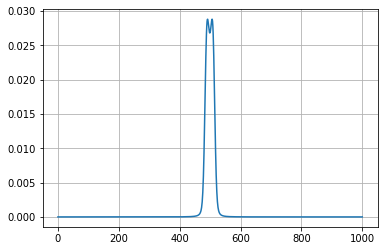

In [29]:
cs = np.sum(sii,axis=0) #cross section
idx = np.argmax(cs==max(cs))
ratio = sum(cs[idx-1:idx+2])/0.21*0.2
print('peak pixel flux/total flux = %.4f'%ratio)
plt.plot(cs)
plt.grid()

In [30]:
sum(cs)

0.9999999999999997

In [31]:
def findWidth(cs, y):
    peak = max(cs)
    idx_peak1 = np.argmax(abs(cs-peak)/peak<0.001)
    #print(idx_peak1, len(cs))
    valley_width = len(cs)-idx_peak1*2
    x1=np.arange(idx_peak1+1)
    curve1 = cs[x1]
    if valley_width > 0:
        idx_peak2 = idx_peak1+valley_width
        valley = min(cs[idx_peak1:idx_peak2])
        idx_valley = np.argmax(cs==valley)
        x2=np.arange(idx_peak1, idx_valley)
        curve2 = cs[x2][::-1]
        x2 = x2-idx_peak1
    if y>peak:
        width = 0
    else:
        x = np.interp(y, curve1, x1)
        if valley_width > 0:
            width = idx_valley - x
            # comment out 2 lines below, if pixels inside the valley will not be used.
            if y>valley:
                width = width - np.interp(y, curve2, x2)
        else:
            width = idx_peak1 - x
        width = width*2
    return width

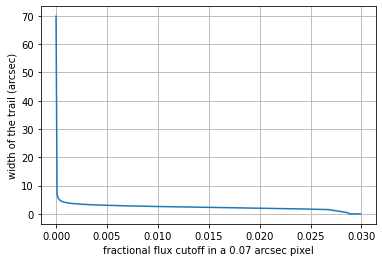

In [32]:
testy = np.arange(0, 0.03, 0.0001)
testx = np.zeros(len(testy))
for i,y in enumerate(testy):
    testx[i] = findWidth(cs,y)*0.07
plt.plot(testy, testx)
plt.xlabel('fractional flux cutoff in a 0.07 arcsec pixel')
plt.ylabel('width of the trail (arcsec)')
plt.grid()

### Baseline LSST system, as defined in syseng_throughput

In [33]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [34]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
effarea=np.pi*(6.423/2*100)**2
X=1.0

# PhotometricParameters object for standard m5 calculations.
photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Let's make sure we can reproduce standard m5 results

In [35]:
m5 = st.makeM5(hardware, system, darksky=None, 
                      exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                      effarea=effarea, X=1.0)

In [36]:
m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


Set up the dataframe

In [37]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
properties = ['SatLim', 'XTalkLim']
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')

### Satellites have solar SED

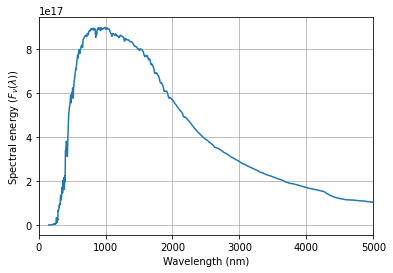

In [38]:
satellite = Sed()
satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
satellite.flambdaTofnu()
plt.plot(satellite.wavelen, satellite.fnu)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Spectral energy ($F_\nu(\lambda)$)')
plt.xlim([0, 5000])
plt.grid()

### Calculate the saturation limits under darksky: the source should have solar SED

In [39]:
# change exposure to dt
photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
for f in system:
    satellite = Sed()
    satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
    fNorm = satellite.calcFluxNorm(0, system[f])
    # print('fNorm = %.2e'%fNorm)
    satellite.multiplyFluxNorm(fNorm)
    adu = satellite.calcADU(system[f], photParams=photParams_dt)
    #print(satellite.calcMag(system[f]))
    
    flatsource = Sed()
    flatsource.setFlatSED()
    adu_flat = flatsource.calcADU(system[f], photParams=photParams_dt)
    print('%s, adu = %e, adu_flat = %e, diff = %.2f'%(f, adu, adu_flat, adu-adu_flat))
    #So the ADU is the same as using the flat SED. Does that make sense?
    #yes, according to Lynne. Because the AB magnitude, and the flux, both include the effect of the bandpass (throughput)
    #therefore are specific for each observatory. That is why calcFluxNorm() has system[f] as input.
    #The mapping from mag to flux inside a particular bandpass is unique, and have nothing to do with SED
    
    adu0 = adu*ratio
    #because we assumed a m=0 star
    # we use gain=1.0, so adu = number of e-
    # we also get rid of skycounts from each pixel. This has miminal effect on results
    d['SatLim'].loc[f] = np.log10(adu0/(full_well-m5.skyCounts.loc[f]))/2*5
    d['XTalkLim'].loc[f] = np.log10(adu0/(xtalk_limit-m5.skyCounts.loc[f]))/2*5

r, adu = 2.073579e+07, adu_flat = 2.073579e+07, diff = -0.00
i, adu = 1.576086e+07, adu_flat = 1.576086e+07, diff = 0.00
u, adu = 7.070173e+06, adu_flat = 7.070173e+06, diff = -0.00
z, adu = 1.092646e+07, adu_flat = 1.092646e+07, diff = -0.00
g, adu = 2.543741e+07, adu_flat = 2.543741e+07, diff = 0.00
y, adu = 5.257237e+06, adu_flat = 5.257237e+06, diff = -0.00


#### Double-check: do the same calculation using zero points

In [40]:
d_zp = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    #number of electrons we can accomodate for the source in dt sec
    ne = (full_well-m5.skyCounts[f])/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/dt
    d_zp['SatLim'].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))
    ne = (xtalk_limit-m5.skyCounts[f])/ratio
    ne = ne/dt
    d_zp['XTalkLim'].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [41]:
d_zp

,SatLim,XTalkLim
u,1.468425,4.416881
g,2.860926,5.843752
r,2.642009,5.669045
i,2.346741,5.413969
z,1.953446,5.093907
y,1.163458,4.380221


In [42]:
round(d_zp - d)  #should be idential to above calculations

,SatLim,XTalkLim
u,0.0,0.0
g,-0.0,-0.0
r,0.0,0.0
i,-0.0,-0.0
z,0.0,0.0
y,0.0,0.0


### Make peak electron counts vs. mag plot

In [43]:
pRatio = ratio
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')

u, 112055, 81, 1386.119, 15.918
g, 403156, 411, 980.688, 18.854
r, 328640, 819, 401.369, 15.457
i, 249793, 1173, 212.864, 13.143
z, 173173, 1783, 97.125, 10.748
y, 83322, 2371, 35.142, 8.029


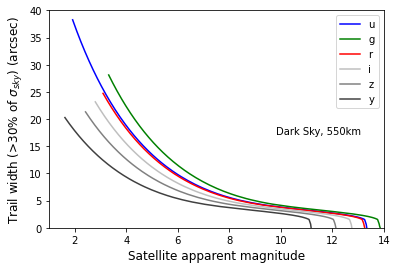

In [45]:
magLow = 0
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    widths = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_dt)
    cut = 0
    magX = -999
    for m in range(651):
        mag = magLow+1 + 0.02 * m
        mags.append(mag)
        nSat = adu*10**(-mag/2.5)
        npeak = nSat*pRatio + m5.skyCounts[f]
        if npeak>full_well2:
            width = np.nan
        else:
            width = findWidth(cs, noiseThresh*np.sqrt(m5.skyCounts[f])/20*7/nSat)*0.07    #each pixel is 0.07"
            #width = findWidth(cs, 10/10/nSat)*0.02    #each pixel is 10 micron
            if cut==1 or widths[-1]==0:
                cut = 1
                width = np.nan
        if magX<0 and npeak<xtalk_limit:
            magX = mag
            widthX = width
        if mag == 4.5:
            print('%s, %.0f, %.0f, %.3f, %.3f'%(f, nSat, m5.skyCounts[f], nSat/m5.skyCounts[f], width))
        #print('%.1f, %9.3f, %.2f'%(mag, nSat*pRatio/m5.skyCounts[f], width))#when the ratio is ~0.4, width should be ~2.57arcsec
        widths.append(width)
    #plt.scatter(mags, widths, label=f, color=colors[i])
    plt.plot(mags, widths, '-', label=f, color=colors[i])
    #plt.plot(magX, widthX, 'o', color=colors[i])
    #print(npeak)
    #break
    #d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
#plt.plot([magLow, magLow+7.0],[xtalk_limit, xtalk_limit], ls = '--', lw = 2, color='black')
#plt.text(magLow+0.5, xtalk_limit*0.3, "Range of correctable crosstalk", color = 'black')
#plt.text(0.5, xtalk_limit*0.3, "crosstalk = %d e-"%xtalk_limit, color = 'black')
#plt.plot([magLow+0,magLow+7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
#plt.text(magLow+3.4, full_well2*1.20, "Saturation = %d e-"%full_well2, color = 'black')
#plt.text(0.15, 0.43, "Trail FWHM = %.2f arcsec"%(fwhm_exp/pixel_size*plate_scale), color = 'black', transform=fig.transFigure)
plt.text(0.65, 0.45, "Dark Sky, 550km", color = 'black', transform=fig.transFigure)
plt.legend(loc='upper right')
#plt.fill_between([magLow+0,magLow+7.0], [xtalk_limit, xtalk_limit], facecolor='grey', alpha=0.2)
#plt.yscale('log')
plt.xlim(magLow+1,magLow+14.0)
plt.ylim(0, 40)
#plt.grid()
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel(r'Trail width (>%.0f%% of $\sigma_{sky}$) (arcsec)'%(noiseThresh*100), fontsize=12);
#plt.grid()
plt.savefig('width_by_band_550km_darkSky.pdf')